In [153]:
INIT_ETH   = 10                       # 初始底池有 10 ETH及對應價值的 USDC
W_FACTOR   = 1                        # “底池一倍” → w = 1 * k
BASIS      = 0.5                      # 年化波動率 50%

In [154]:
import requests, pandas as pd

def load_eth_prices_coingecko(days: int = 30) -> pd.DataFrame:
    """回傳 DataFrame：date, price_usd"""
    url = "https://api.coingecko.com/api/v3/coins/ethereum/market_chart"
    params = {
        "vs_currency": "usd",
        "days": days,
        "interval": "daily",  # 日線 (UTC 00:00)
    }
    r = requests.get(url, params=params, timeout=10)
    r.raise_for_status()
    data = r.json()["prices"]  # [ [timestamp_ms, price], ... ]

    df = pd.DataFrame(data, columns=["ts_ms", "price_usd"])
    df["date"] = pd.to_datetime(df["ts_ms"], unit="ms").dt.date
    return df[["date", "price_usd"]]


# 使用範例
eth_price_30_days_df = load_eth_prices_coingecko(30)
print(eth_price_30_days_df.tail())

          date    price_usd
26  2025-04-15  1621.543196
27  2025-04-16  1587.822224
28  2025-04-17  1577.707352
29  2025-04-18  1583.476450
30  2025-04-18  1583.778100


In [155]:
# ==================================
# Dyson V2 30 天回測 – ETH/USDC 池
# ==================================
import math, random, datetime as dt
import numpy as np, pandas as pd


# ---------- 1. 輔助函式 ----------
def sqrt(x):  # 省打字
    return math.sqrt(x)


def calc_discount(a, b):
    if b <= a:
        raise ValueError("b 必須 > a")
    if a == 0:
        return math.log2(b + 1) / b * math.log(2)
    num = (math.log2(b + 1) - math.log2(a + 1)) * math.log(2)
    return num / (b - a)


def rebalance(eth_balance: float, usdc_balance: float, price: float):
    """
    目標：使池子價值 (ETH*price 與 USDC) 各占 50%。
    回傳 (調整後的 eth_balance, usdc_balance)
    """
    eth_value = eth_balance * price
    total_value = eth_value + usdc_balance
    target_val = total_value / 2

    # ETH 太多 → 賣 ETH 換 USDC
    if eth_value > target_val:
        excess_val = eth_value - target_val
        eth_to_sell = excess_val / price
        return eth_balance - eth_to_sell, usdc_balance + excess_val

    # USDC 太多 → 買 ETH
    elif usdc_balance > target_val:
        excess_val = usdc_balance - target_val
        eth_to_buy = excess_val / price
        return eth_balance + eth_to_buy, usdc_balance - excess_val

    return eth_balance, usdc_balance  # 已平衡

# --- 測試 ---
test_cases = [
    (0, 0.001),
    (0, 0.1),
    (0.9, 0.999),
    (0.9, 1.0),
]

for a, b in test_cases:
    d_log2 = calc_discount(a, b)
    print(f"[{a}, {b}] => discount={d_log2:.4f}")

(newEthBalance, newUsdcBalance) = rebalance(110, 200000, 2000)
print(f"New ETH Balance: {newEthBalance}, New USDC Balance: {newUsdcBalance}")

[0, 0.001] => discount=0.9995
[0, 0.1] => discount=0.9531
[0.9, 0.999] => discount=0.5131
[0.9, 1.0] => discount=0.5129
New ETH Balance: 105.0, New USDC Balance: 210000.0


In [156]:
# ---------- 2. DysonPool ----------
class Note:
    def __init__(self, t0_amt, t1_amt, due):
        self.t0_amt = t0_amt
        self.t1_amt = t1_amt
        self.due = due  # UTC 日數 (int)


class DysonPool:
    def __init__(self, init_eth, init_usdc, basis):
        self.x = init_eth
        self.y = init_usdc
        self.k_last = sqrt(self.x * self.y)
        self.w = self.k_last * W_FACTOR  # “底池一倍”
        self.basis = basis
        self.q_sold = {}  # due_day -> Q 累積
        self.notes = []  # [(Note, owner_id)]

    # ------- 覆刻 Solidity 公式 -------
    def _rebalance_after_op(self, price: float):
        self.x, self.y = rebalance(self.x, self.y, price)
        # rebalance 後更新 k_last，模擬 on‑chain sync()
        self.k_last = sqrt(self.x * self.y)

    def _calc_premium_update_q(self, Q, due_day, now_day):
        q_old = self.q_sold.get(due_day, 0)
        q_new = q_old + Q
        a, b = q_old / self.w, q_new / self.w

        # premium ratio
        discount = calc_discount(a, b)
        t_year = (due_day - now_day) / 365
        base_rt = 0.4 * self.basis * math.sqrt(t_year)
        premium = base_rt * discount  # 單位：ratio

        self.q_sold[due_day] = q_new
        return premium

    def deposit(self, user_id, in0, in1, lock_days, now_day, price):
        assert in0 > 0 or in1 > 0
        due_day = now_day + lock_days

        k_before = sqrt(self.x * self.y)
        k_after = sqrt((self.x + in0) * (self.y + in1))
        assert k_before >= self.k_last  # Invariant
        diff = k_after - k_before
        Q_sq = 4 * diff * diff
        Q = math.sqrt(Q_sq)

        if in0 * self.y > in1 * self.x:
            ratio = (in1 * self.x) / self.y if self.y > 0 else 0
            note0_amt = in0 + ratio
            note1_amt = Q_sq / note0_amt
        else:
            ratio = (in0 * self.y) / self.x if self.x > 0 else 0
            note1_amt = in1 + ratio
            note0_amt = Q_sq / note1_amt

        premium_ratio = self._calc_premium_update_q(Q, due_day, now_day)
        note0_amt *= 1 + premium_ratio
        note1_amt *= 1 + premium_ratio

        # 更新池子儲備
        self.x += in0
        self.y += in1
        self.k_last = k_after
        self._rebalance_after_op(price)

        note = Note(note0_amt, note1_amt, due_day)
        self.notes.append((note, user_id))
        return note0_amt, note1_amt, premium_ratio

    def withdraw_due(self, now_day, price):
        """掃描到期 note，全部領回；回傳列表 (owner, amt0, amt1)"""
        payouts = []
        still_open = []
        for note, uid in self.notes:
            if note.due <= now_day:
                # Solidity _calculateWithdrawal
                num = (
                    self.x * note.t1_amt
                    + note.t0_amt * note.t1_amt
                    - self.y * note.t0_amt
                )
                if num > 0:
                    ratio = min(num * 1e18 / (2 * note.t0_amt * note.t1_amt), 1e18)
                else:
                    ratio = 0
                amt0 = ratio * note.t0_amt / 1e18
                amt1 = (1e18 - ratio) * note.t1_amt / 1e18

                # 更新池子
                self.x -= amt0
                self.y -= amt1
                self.k_last = sqrt(self.x * self.y)
                self._rebalance_after_op(price)
                payouts.append((uid, amt0, amt1))
            else:
                still_open.append((note, uid))
        self.notes = still_open
        return payouts

    def snapshot(self, day, price):
        return {
            "day": day,
            "price": price,
            "reserve_eth": self.x,
            "reserve_usdc": self.y,
            "k": sqrt(self.x * self.y),
        }

# --- 測試 ---
test_cases = [
    (0.0005, 1, 0),
    (0.0005, 2, 1),
]
pool = DysonPool(INIT_ETH, INIT_ETH * 2000, BASIS)

for Q, dueDay, nowDay in test_cases:
    premium = pool._calc_premium_update_q(Q, dueDay, nowDay)
    print(f"[{Q}, {dueDay}, {nowDay}] => premium={premium:.4f}")

[0.0005, 1, 0] => premium=0.0105
[0.0005, 2, 1] => premium=0.0105


In [157]:
# ---------- 3. 單日模擬 ----------
def simulate_day(pool: DysonPool, day: int, price: float, min_users=1, max_users=10):
    deposits, withdraws = [], []

    # 1) 隨機 withdraw 到期 note
    wds = pool.withdraw_due(day, price)
    for uid, a0, a1 in wds:
        withdraws.append({"day": day, "user": uid, "amt0": a0, "amt1": a1})

    # 2) 隨機產生 deposit
    n_users = random.randint(min_users, max_users)
    for uid in range(n_users):
        single_side = random.choice([True, False])
        if single_side:
            if random.random() < 0.5:  # 只存 ETH
                in0 = round(random.uniform(0.01, 0.5), 4)
                in1 = 0
            else:  # 只存 USDC
                in0 = 0
                in1 = round(random.uniform(50, 2000), 2)
        else:  # 雙邊
            in0 = round(random.uniform(0.01, 0.5), 4)
            in1 = round(in0 * price, 2)
        lock = random.randint(1, 30)

        note0, note1, prem = pool.deposit(uid, in0, in1, lock, day, price)
        deposits.append(
            {
                "day": day,
                "user": uid,
                "in0": in0,
                "in1": in1,
                "note0": note0,
                "note1": note1,
                "premium_ratio": prem,
                "lock": lock,
            }
        )
    return deposits, withdraws

In [158]:
# ---------- 4. 主迴圈 ----------
def run_backtest(days):
    eth_price_df = load_eth_prices_coingecko(days)
    prices = eth_price_df["price_usd"].tolist()
    first_price = prices[0]

    pool = DysonPool(INIT_ETH, INIT_ETH * first_price, BASIS)
    daily_snap, all_dep, all_wd = [], [], []

    for d, p in enumerate(prices, start=1):
        dep, wd = simulate_day(pool, d, p)
        all_dep.extend(dep)
        all_wd.extend(wd)
        daily_snap.append(pool.snapshot(d, p))

    return (pd.DataFrame(all_dep), pd.DataFrame(all_wd), pd.DataFrame(daily_snap))

# 執行回測
### 60 天回測

In [159]:
import matplotlib.pyplot as plt, seaborn as sns

deposits_df, withdraws_df, daily_state_df = run_backtest(30)

if "price" not in deposits_df.columns:
    deposits_df = deposits_df.merge(daily_state_df[["day", "price"]], on="day")

deposits_df["invest_usd"] = (
    deposits_df["in0"] * deposits_df["price"] + deposits_df["in1"]
)

deposits_df["premium_usd"] = (
    deposits_df["note0"] - (deposits_df["note0"] / (1 + deposits_df["premium_ratio"]))
) * deposits_df["price"] + (deposits_df["note1"] - deposits_df["note1"]) / (
    1 + deposits_df["premium_ratio"]
)

deposits_df["apr"] = (
    deposits_df["premium_usd"] / deposits_df["invest_usd"] * 365 / deposits_df["lock"]
)
deposits_df["side"] = deposits_df.apply(
    lambda r: "Single" if (r["in0"] == 0) or (r["in1"] == 0) else "Dual", axis=1
)

deposits_df.head()

,day,user,in0,in1,note0,note1,premium_ratio,lock,price,invest_usd,premium_usd,apr,side
0,1,0,0.4686,965.66,0.963727,1985.979219,0.028303,8,2060.728601,1931.317422,54.661796,1.291318,Dual
1,1,1,0.0000,438.56,0.216028,449.688336,0.025375,6,2060.728601,438.560000,11.016638,1.528135,Single
2,2,0,0.0000,598.35,0.295788,617.877672,0.032636,10,1980.831781,598.350000,18.517209,1.129570,Single
3,2,1,0.1552,307.43,0.323600,640.998052,0.042519,17,1980.831781,614.855092,26.142959,0.912906,Dual
4,2,2,0.0279,55.27,0.058059,115.004558,0.040434,15,1980.831781,110.535207,4.469351,0.983888,Dual


In [160]:
withdraws_df.head()

,day,user,amt0,amt1
0,4,1,0.078710,154.628436
1,6,2,0.252877,1040.350834
2,6,0,0.000000,426.412708
3,7,1,0.122193,195.329265
4,8,2,0.591558,266.292984


In [161]:
daily_state_df.head()

,day,price,reserve_eth,reserve_usdc,k
0,1,2060.728601,10.575010,21792.224722,480.055190
1,2,1980.831781,11.122419,22031.640050,495.020324
2,3,1964.529383,12.401501,24363.112765,549.671869
3,4,1979.544926,12.431754,24609.216168,553.114572
4,5,2001.047023,14.885065,29785.714295,665.854551


<Axes: xlabel='day'>

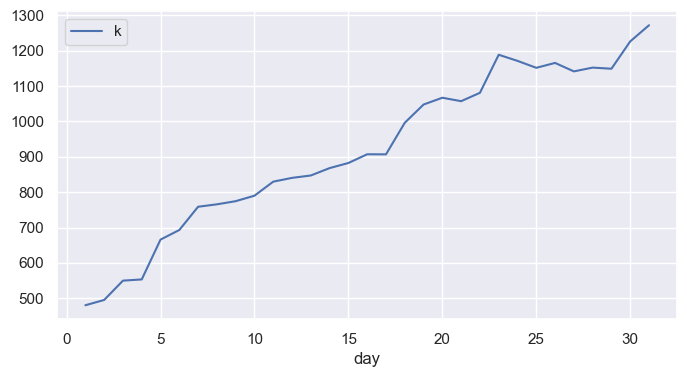

In [162]:
daily_state_df.plot(x="day", y="k", figsize=(8, 4))

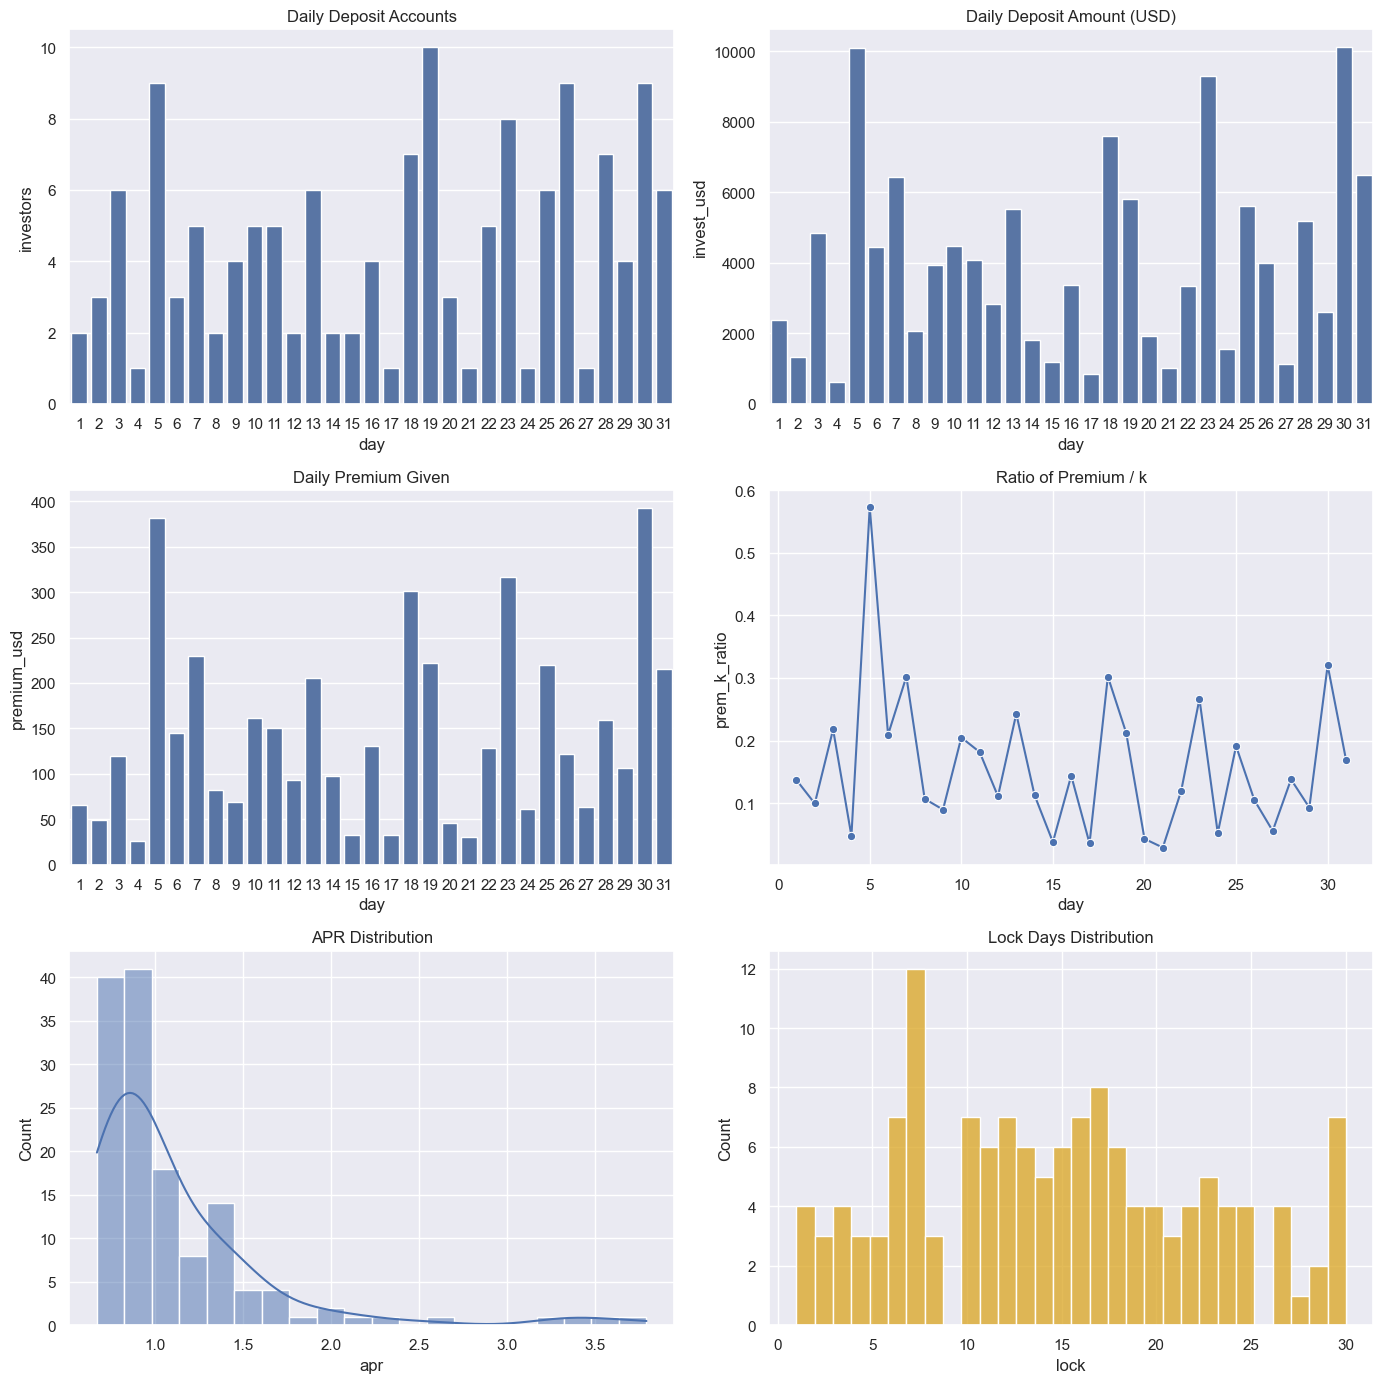

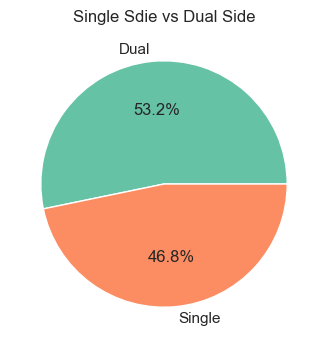

In [163]:
daily_stats = (
    deposits_df.groupby("day")
    .agg(
        investors=("user", "nunique"),
        invest_usd=("invest_usd", "sum"),
        premium_usd=("premium_usd", "sum"),
    )
    .reset_index()
)

ratio_df = daily_state_df.merge(daily_stats[["day", "premium_usd"]], on="day")
ratio_df["prem_k_ratio"] = ratio_df["premium_usd"] / ratio_df["k"]

sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(3, 2, figsize=(14, 14))
axs = axs.flatten()

sns.barplot(x="day", y="investors", data=daily_stats, ax=axs[0])
axs[0].set_title("Daily Deposit Accounts")
sns.barplot(x="day", y="invest_usd", data=daily_stats, ax=axs[1])
axs[1].set_title("Daily Deposit Amount (USD)")
sns.barplot(x="day", y="premium_usd", data=daily_stats, ax=axs[2])
axs[2].set_title("Daily Premium Given")
sns.lineplot(x="day", y="prem_k_ratio", data=ratio_df, marker="o", ax=axs[3])
axs[3].set_title("Ratio of Premium / k")
sns.histplot(deposits_df["apr"], bins=20, kde=True, ax=axs[4])
axs[4].set_title("APR Distribution")
sns.histplot(deposits_df["lock"], bins=30, color="goldenrod", ax=axs[5])
axs[5].set_title("Lock Days Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 4))
deposits_df["side"].value_counts().plot.pie(
    autopct="%1.1f%%", colors=["#66c2a5", "#fc8d62"]
)
plt.title("Single Sdie vs Dual Side")
plt.ylabel("")
plt.show()